In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import ast
import progressbar
import os

 First we load all the dataset that we will be using

In [2]:
# Data paths (folder and path are seperated in order to easily check if the pickle version of the file exists)
characters_metadata_path    = {'path':'./data/MovieSummaries/character.metadata',   'extension':'.tsv'}
movies_metadata_path        = {'path':'./data/MovieSummaries/movie.metadata',       'extension':'.tsv'}
movie_summaries_path        = {'path':'./data/MovieSummaries/plot_summaries',       'extension':'.txt'}

imdb_names_path         = {'path':'./data/imdb/imdb_names',         'extension':'.tsv'} 
imdb_principals_path    = {'path':'./data/imdb/imdb_principals',    'extension':'.tsv'}
imdb_ratings_path       = {'path':'./data/imdb/imdb_ratings',       'extension':'.tsv'} 
imdb_titles_path        = {'path':'./data/imdb/imdb_titles',        'extension':'.tsv'}

kaggle_awards_path = {'path':'./data/kaggle/the_oscar_award', 'extension':'.csv'}

# Column names for the MCU datasets (since they are not provided in the datasets themselves)
colnames_charac = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date', 'Character name', 'Actor date of birth', 'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor name', 'Actor age', 'Freebase character/actor map ID', 'Freebase character ID', 'Freebase actor ID']
colnames_movie = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres'] 
colnames_plot = ['Wikipedia movie ID', 'Plot'] 

In [3]:
pkl_extension = ".pkl"
def load_and_pickle(data_dict, default_load):
    if os.path.exists(data_dict['path'] + pkl_extension):
        print('Pickle file found for {}.'.format(data_dict['path']))
        return pd.read_pickle(data_dict['path'] + pkl_extension)
    else:
        print('No pickle found for {}. Creating it...'.format(data_dict['path']))
        df = default_load(''.join(data_dict.values()))
        df.to_pickle(data_dict['path'] + pkl_extension)
        return df

In [4]:
# Takes ~2 minute without pickles, ~20 seconds with pickles

# Load datasets 
meta_charac_raw = load_and_pickle(characters_metadata_path, lambda path: pd.read_csv(path, names=colnames_charac, sep='\t'))
meta_movie_raw  = load_and_pickle(movies_metadata_path, lambda path: pd.read_csv(path, names=colnames_movie, sep='\t'))
plot            = load_and_pickle(movie_summaries_path, lambda path: pd.read_csv(path, names=colnames_plot, sep="\t"))

# Load IMDB datasets
imdb_names      = load_and_pickle(imdb_names_path, lambda path: pd.read_csv(path, header=0, sep='\t'))
imdb_principals = load_and_pickle(imdb_principals_path, lambda path: pd.read_csv(path, header=0, sep='\t'))
imdb_raitings   = load_and_pickle(imdb_ratings_path, lambda path: pd.read_csv(path, header=0 , sep='\t'))
imdb_title      = load_and_pickle(imdb_titles_path, lambda path: pd.read_csv(path, header=0, sep='\t', dtype= "string"))

# Load kaggle awards dataset
kaggle_awards = load_and_pickle(kaggle_awards_path, lambda path: pd.read_csv(path, header=0))

Pickle file found for ./data/MovieSummaries/character.metadata.
Pickle file found for ./data/MovieSummaries/movie.metadata.
Pickle file found for ./data/MovieSummaries/plot_summaries.
Pickle file found for ./data/imdb/imdb_names.
Pickle file found for ./data/imdb/imdb_principals.
Pickle file found for ./data/imdb/imdb_ratings.
Pickle file found for ./data/imdb/imdb_titles.
Pickle file found for ./data/kaggle/the_oscar_award.


## Initial data analysis
First we will drop le columns that we will not be using as to not clutter our analysis


In [30]:
movie_columns_used = ['Wikipedia movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie genres'] 
charac_columns_used = ['Wikipedia movie ID', 'Movie release date', 'Character name', 'Actor date of birth', 'Actor gender', 'Actor ethnicity', 'Actor name', 'Actor age']
meta_movie = meta_movie_raw[movie_columns_used].copy()
meta_charac = meta_charac_raw[charac_columns_used].copy()

In [31]:
print("--- Meta Movie ---")
print(meta_movie.dtypes.to_string())
print("--- Meta Character ---")
print(meta_charac.dtypes.to_string())
print("--- Plot ---")
print(plot.dtypes.to_string())

--- Meta Movie ---
Wikipedia movie ID            int64
Movie name                   object
Movie release date           object
Movie box office revenue    float64
Movie genres                 object
--- Meta Character ---
Wikipedia movie ID       int64
Movie release date      object
Character name          object
Actor date of birth     object
Actor gender            object
Actor ethnicity         object
Actor name              object
Actor age              float64
--- Plot ---
Wikipedia movie ID     int64
Plot                  object


In [8]:
#TODO Check if we need ot do this ... -> objects are with NaNs I guess...
# meta_movie['Movie name'] = meta_movie['Movie name'].astype(str)

# For consistency we remove day and month from actor date of birth and movie release date.
meta_movie["Movie release date"] = meta_movie["Movie release date"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())

# turn movie genres into dictionary
meta_movie['Movie genres'] = meta_movie['Movie genres'].apply(ast.literal_eval)
# meta_charac[['Character name', 'Actor gender','Actor ethnicity','Actor name']] = meta_charac[['Character name', 'Actor gender','Actor ethnicity','Actor name']].astype(str)
meta_charac["Movie release date"] = meta_charac["Movie release date"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())
meta_charac["Actor date of birth"] = meta_charac["Actor date of birth"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())


TODO : Mieux expliquer

We will start by filtering the data by adding the IMDb scores. To do this we will need to have a look at the IMDb dataset.  Once the filtering id finished, we will then analyse what we have left.

In [9]:
meta_movie

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie genres
0,975900,Ghosts of Mars,2001,14010832.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp..."
2,28463795,Brun bitter,1988,NaN,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D..."
3,9363483,White Of The Eye,1987,NaN,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic..."
4,261236,A Woman in Flames,1983,NaN,{'/m/07s9rl0': 'Drama'}
...,...,...,...,...,...
81736,35228177,Mermaids: The Body Found,2011,NaN,{'/m/07s9rl0': 'Drama'}
81737,34980460,Knuckle,2011,NaN,"{'/m/03bxz7': 'Biographical film', '/m/07s9rl0..."
81738,9971909,Another Nice Mess,1972,NaN,"{'/m/06nbt': 'Satire', '/m/01z4y': 'Comedy'}"
81739,913762,The Super Dimension Fortress Macross II: Lover...,1992,NaN,"{'/m/06n90': 'Science Fiction', '/m/0gw5n2f': ..."


In [10]:
imdb_movieTitle = imdb_title[imdb_title['titleType'] == 'movie'].copy() #keep only movies
imdb_movieTitle = imdb_movieTitle[imdb_movieTitle['startYear'] != '\\N'].copy() #remove nan years
imdb_movieTitle['startYear'] = imdb_movieTitle['startYear'].astype(int) # turn year to int
imdb_names.rename(columns={'nconst':'IMDb_actor_ID'}, inplace=True)
imdb_principals.rename(columns={'nconst':'IMDb_actor_ID'}, inplace=True)
imdb_principals.rename(columns={'tconst':'IMDb_ID'}, inplace=True)

movies = meta_movie\
            .merge(imdb_movieTitle[['originalTitle','startYear','tconst']], left_on= ['Movie name', 'Movie release date'], right_on= ['originalTitle','startYear'], how= 'inner')\
            .merge(imdb_raitings, how ='inner')
movies.rename(columns={"tconst":"IMDb_ID"}, inplace= True)

print("--- Movie dataset size ---")
print(movies.shape)
movies

--- Movie dataset size ---
(35612, 10)


,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie genres,originalTitle,startYear,IMDb_ID,averageRating,numVotes
0,975900,Ghosts of Mars,2001,14010832.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",Ghosts of Mars,2001,tt0228333,4.9,56930
1,28463795,Brun bitter,1988,NaN,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",Brun bitter,1988,tt0094806,5.6,41
2,10408933,Alexander's Ragtime Band,1938,3600000.0,"{'/m/04t36': 'Musical', '/m/01z4y': 'Comedy', ...",Alexander's Ragtime Band,1938,tt0029852,6.8,2270
3,175026,Sarah and Son,1930,NaN,"{'/m/07s9rl0': 'Drama', '/m/01g6gs': 'Black-an...",Sarah and Son,1930,tt0021335,5.4,300
4,171005,Henry V,1989,10161099.0,"{'/m/04xvh5': 'Costume drama', '/m/082gq': 'Wa...",Henry V,1989,tt0097499,7.5,31214
...,...,...,...,...,...,...,...,...,...,...
35607,24209227,"The Time, the Place and the Girl",1946,NaN,"{'/m/05p553': 'Comedy film', '/m/02l7c8': 'Rom...","The Time, the Place and the Girl",1946,tt0039038,5.9,348
35608,15394941,Gopi Kishan,1994,NaN,"{'/m/07s9rl0': 'Drama', '/m/02kdv5l': 'Action'...",Gopi Kishan,1994,tt0109922,5.8,964
35609,23851782,The Ghost Train,1941,NaN,"{'/m/0lsxr': 'Crime Fiction', '/m/01jfsb': 'Th...",The Ghost Train,1941,tt0033660,6.2,1582
35610,34980460,Knuckle,2011,NaN,"{'/m/03bxz7': 'Biographical film', '/m/07s9rl0...",Knuckle,2011,tt1606259,6.8,3194


We will now have a look at the resulting datasets

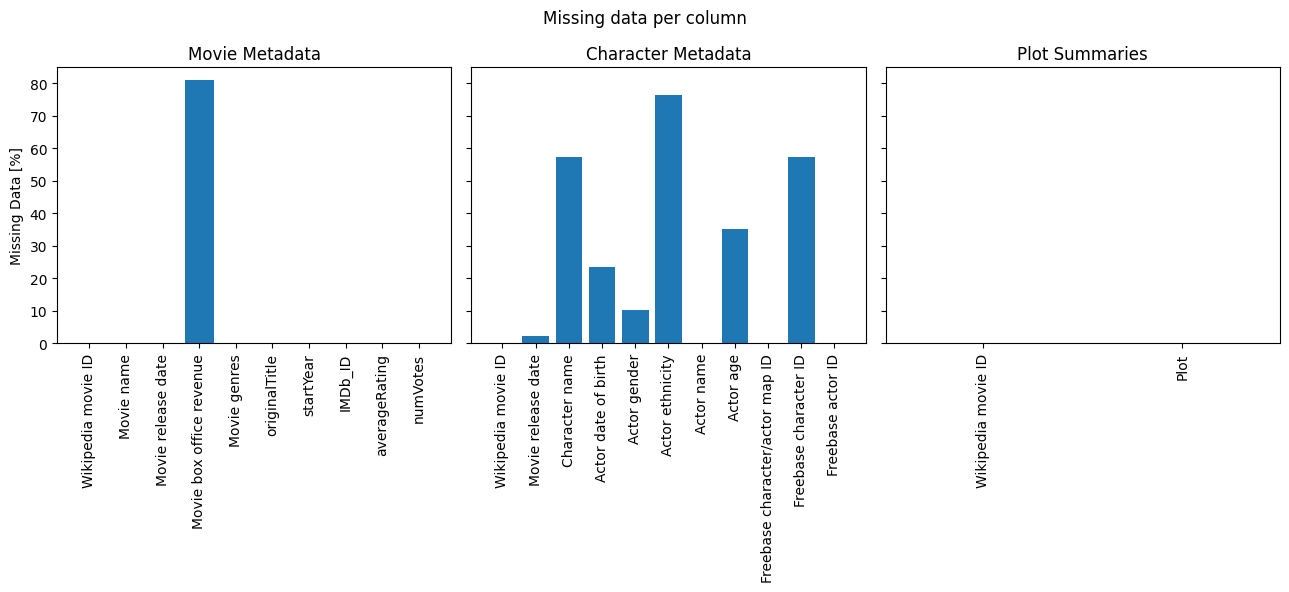

--- Dataset shapes ---
Movies metadata: (35612, 10)
Character metadata: (35612, 10)
Plot summaries: (42303, 2)


In [11]:
# Calculating missing data
missing_movie = movies.isnull().sum() * 100 / len(movies)
missing_char = meta_charac.isnull().sum() * 100 / len(meta_charac)
missing_plot = plot.isnull().sum() * 100 / len(plot)

#Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 6), sharey=True)
fig.suptitle('Missing data per column')

ax1.set(ylabel= 'Missing Data [%]')
ax1.bar(missing_movie.index, missing_movie.values)
ax1.tick_params(axis='x', labelrotation = 90)
ax1.set_title("Movie Metadata")
ax2.bar(missing_char.index, missing_char.values)
ax2.tick_params(axis='x', labelrotation = 90)
ax2.set_title("Character Metadata")
ax3.bar(missing_plot.index, missing_plot.values)
ax3.tick_params(axis='x', labelrotation = 90)
ax3.set_title("Plot Summaries")
plt.tight_layout()
plt.show()

print("--- Dataset shapes ---")
print("Movies metadata: {}" .format(movies.shape))
print("Character metadata: {}" .format(movies.shape))
print("Plot summaries: {}" .format(plot.shape))

From this initial analysis we can see that there is alot of missing data and that we should be carefull when selecting the actor features.


Now lets work on the movie genres, at the moment they are a long string: "{"/m/014dsx": "Travel", "/m/0219x_": "Indie", "/m/0jtdp": "Documentary"}". We can use the fact that they are a dictionary

In [18]:
# N.B Takes 20s to run
def count_genres(dictionary):
    return pd.Series(list(dictionary.values())).value_counts()

# Apply the custom function to the column
genre_counts = movies['Movie genres'].apply(count_genres).fillna(0).sum()


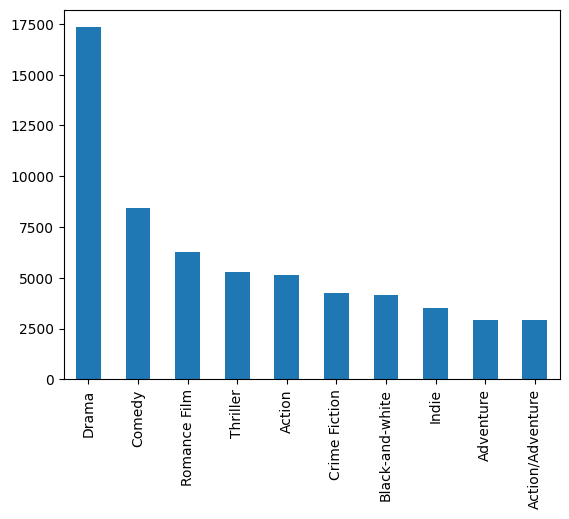

In [13]:
# Plot top 10 most represented genres
genre_counts = genre_counts.sort_values(ascending=False).head(10)
genre_counts.plot.bar()
drama_films = movies[movies['Movie genres'].apply(lambda x: 'Drama' in x.values())]
comedy_films = movies[movies['Movie genres'].apply(lambda x: 'Comedy' in x.values())]
romance_films = movies[movies['Movie genres'].apply(lambda x: 'Romance Film' in x.values())]

We will now look at the temporal distribution of films

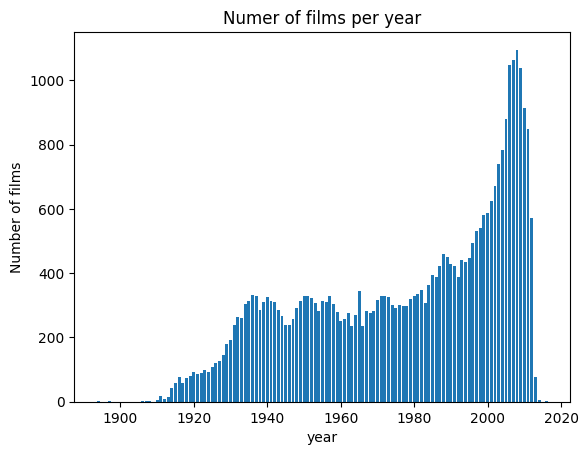

In [19]:

# Plot movies / year
movie_counts = movies['Wikipedia movie ID'].groupby(movies['Movie release date']).count()
plt.bar(movie_counts.index,movie_counts.values)
plt.title('Numer of films per year')
plt.xlabel('year')
plt.ylabel('Number of films')
plt.show()

TODO: Don't need any more
Since the first film is believed to have been recorded in 1888 [_Wikipedia_]. So there is a problem here: A typo in the data has put a film from 2010 as 1010

earliest film before typo correction: 1894
earliest film after typo correction: 1894


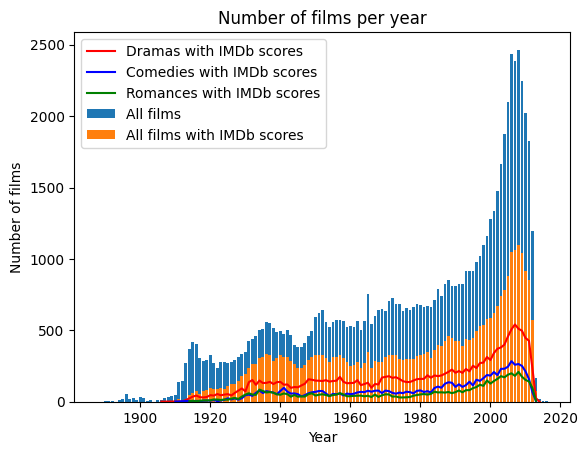

In [21]:
print("earliest film before typo correction: {}" .format(movies['Movie release date'].min()))

#correction TODO Don't need and change underneath
meta_movie["Movie release date"][meta_movie["Movie release date"]==1010] = 2010

print("earliest film after typo correction: {}" .format(movies['Movie release date'].min()))

# Graph
all_movie_counts = meta_movie['Wikipedia movie ID'].groupby(meta_movie['Movie release date']).count()
movie_counts = movies['Wikipedia movie ID'].groupby(movies['Movie release date']).count()
drama_counts = drama_films['Wikipedia movie ID'].groupby(movies['Movie release date']).count()
comedy_counts = comedy_films['Wikipedia movie ID'].groupby(movies['Movie release date']).count()
romance_counts = romance_films['Wikipedia movie ID'].groupby(movies['Movie release date']).count()

plt.bar(all_movie_counts.index, all_movie_counts.values, label= 'All films')
plt.bar(movie_counts.index, movie_counts.values, label= 'All films with IMDb scores')
plt.plot(drama_counts.index, drama_counts.values, 'r-', label='Dramas with IMDb scores')
plt.plot(comedy_counts.index, comedy_counts.values, 'b-',label = 'Comedies with IMDb scores')
plt.plot(romance_counts.index, romance_counts.values, 'g-', label = 'Romances with IMDb scores')

plt.title('Number of films per year')
plt.xlabel('Year')
plt.ylabel('Number of films')
plt.legend()
plt.show()

This is more what we where expecting, an exponential growth in films, exploding in the 1990s. Interestingly we can see that the data drops off after arounf 2010. We will have to be carefull when doing our temporal analyis since the data has such a negative skew.

## Main character extraction

In [22]:
# TODO: Comments
def get_top_actors(movies, imdb_principals, top_n=3):
    imdb_principal_actors = imdb_principals.query('category == "actor" | category == "actress"')
    imdb_principal_actors_valid = imdb_principal_actors[(imdb_principal_actors["IMDb_ID"].isin(movies["IMDb_ID"].values.tolist())) & 
                                                        (imdb_principal_actors["ordering"] <= top_n)]

    movie_actors = []
    bar = progressbar.ProgressBar(maxval=len(movies["IMDb_ID"])).start()
    for idx, id in enumerate(movies["IMDb_ID"]):
        tmp = imdb_principal_actors_valid.loc[imdb_principal_actors_valid["IMDb_ID"] == id][["ordering", "IMDb_actor_ID"]]
        for _, row in tmp.iterrows():
            movie_actors.append([id, row["IMDb_actor_ID"], row["ordering"]])
        bar.update(idx)

    movie_actors = pd.DataFrame(movie_actors, columns=['IMDb_ID', 'actor', 'ordering'])
    return movie_actors

In [23]:
movie_actors = get_top_actors(movies, imdb_principals, 1)
movie_actors.head()

,IMDb_ID,actor,ordering
0,tt0228333,nm0000449,1
1,tt0094806,nm0471903,1
2,tt0029852,nm0000061,1
3,tt0021335,nm0154183,1
4,tt0097499,nm0000110,1


In [24]:
# creation of the DF only with valid actors

movies = movies[movies["IMDb_ID"].isin(movie_actors["IMDb_ID"].unique().tolist())]
movies.head()

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie genres,originalTitle,startYear,IMDb_ID,averageRating,numVotes
0,975900,Ghosts of Mars,2001,14010832.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",Ghosts of Mars,2001,tt0228333,4.9,56930
1,28463795,Brun bitter,1988,NaN,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",Brun bitter,1988,tt0094806,5.6,41
2,10408933,Alexander's Ragtime Band,1938,3600000.0,"{'/m/04t36': 'Musical', '/m/01z4y': 'Comedy', ...",Alexander's Ragtime Band,1938,tt0029852,6.8,2270
3,175026,Sarah and Son,1930,NaN,"{'/m/07s9rl0': 'Drama', '/m/01g6gs': 'Black-an...",Sarah and Son,1930,tt0021335,5.4,300
4,171005,Henry V,1989,10161099.0,"{'/m/04xvh5': 'Costume drama', '/m/082gq': 'Wa...",Henry V,1989,tt0097499,7.5,31214


In [50]:
imdb_names

,IMDb_actor_ID,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0031983,tt0050419,tt0053137,tt0072308"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0037382,tt0038355,tt0075213"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0056404,tt0057345,tt0049189,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0077975,tt0078723,tt0080455,tt0072562"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986"
...,...,...,...,...,...,...
13009996,nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department","tt14069590,tt2455546,tt11657662"
13009997,nm9993716,Essias Loberg,\N,\N,NaN,\N
13009998,nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744
13009999,nm9993718,Aayush Nair,\N,\N,cinematographer,tt8736744


In [53]:
# on pourrait peut-être faire toute l'analyse des genres et nans après le merge final de la case au dessus
# takes ~10 seconds
actors = movie_actors.merge(movies[['Wikipedia movie ID', 'Movie name', 'Movie release date', 'IMDb_ID']], on='IMDb_ID')
actors = actors.merge(imdb_names[['primaryName', 'IMDb_actor_ID']], left_on='actor', right_on='IMDb_actor_ID').drop('IMDb_actor_ID', axis=1)
actors

,IMDb_ID,actor,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName
0,tt0228333,nm0000449,1,975900,Ghosts of Mars,2001,Natasha Henstridge
1,tt0114508,nm0000449,1,689763,Species,1995,Natasha Henstridge
2,tt0120841,nm0000449,1,704406,Species II,1998,Natasha Henstridge
3,tt0129884,nm0000449,1,761361,Dog Park,1998,Natasha Henstridge
4,tt0244196,nm0000449,1,355807,Second Skin,2000,Natasha Henstridge
...,...,...,...,...,...,...,...
34269,tt0228829,nm0848520,1,31026778,Secreto eterno,1942,Marina Tamayo
34270,tt0100666,nm0056492,1,7761830,Spaced Invaders,1990,Douglas Barr
34271,tt0048223,nm0827409,1,28373912,Jan Zizka,1956,Zdenek Stepánek
34272,tt1606259,nm4774206,1,34980460,Knuckle,2011,James Quinn McDonagh


# Awards feature

As a specific actor feature, we want to use the number of awards won. To do this we use a kaggle dataset ([link](https://www.kaggle.com/datasets/unanimad/the-oscar-award/code)).


In [58]:

kaggle_awards = pd.read_csv('./data/kaggle/the_oscar_award.csv', header=0)
display(kaggle_awards)

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10760,2022,2023,95,HONORARY AWARD,"To Euzhan Palcy, a masterful filmmaker who bro...",NaN,True
10761,2022,2023,95,HONORARY AWARD,"To Diane Warren, for her genius, generosity an...",NaN,True
10762,2022,2023,95,HONORARY AWARD,"To Peter Weir, a fearless and consummate filmm...",NaN,True
10763,2022,2023,95,GORDON E. SAWYER AWARD,Iain Neil,NaN,True


We should filter to keep only movies that are in our dataset

In [59]:
kaggle_awards = kaggle_awards[kaggle_awards['name'].isin(actors['primaryName'].unique())]
kaggle_awards = kaggle_awards[kaggle_awards['film'].isin(movies['Movie name'].unique())]
kaggle_awards

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
35,1928,1929,2,ACTOR,George Bancroft,Thunderbolt,False
37,1928,1929,2,ACTOR,Chester Morris,Alibi,False
...,...,...,...,...,...,...,...
10158,2018,2019,91,ACTRESS IN A SUPPORTING ROLE,Marina de Tavira,Roma,False
10270,2019,2020,92,ACTOR IN A LEADING ROLE,Joaquin Phoenix,Joker,True
10279,2019,2020,92,ACTRESS IN A LEADING ROLE,Saoirse Ronan,Little Women,False
10280,2019,2020,92,ACTRESS IN A LEADING ROLE,Charlize Theron,Bombshell,False


Text(0, 0.5, 'Percentage of missing data [%]')

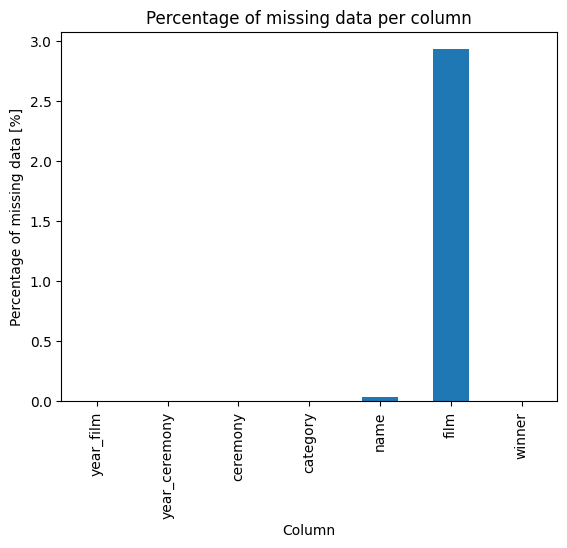

In [42]:
kaggle_nans = kaggle_awards.isnull().sum() * 100 / len(kaggle_awards)
kaggle_nans.plot(kind='bar')
plt.title('Percentage of missing data per column')
plt.xlabel('Column')
plt.ylabel('Percentage of missing data [%]')

As we can see, the dataset is mostly NaNs free.

Let's now define a function to get the number of awards won by a given actor up until a given year. For this feature we will only consider the number of awards that the actor won before the movie was released. Using this function we will be able to add a new column in our previous dataframe. 

The function allow counting both the amount of awards won but also the number of nominations

In [80]:
def count_awards(actor_name, year, win):
    filtered = kaggle_awards.query("year_film < {} & winner == {} & name == \"{}\"".format(year, win, actor_name))
    return len(filtered)

In [83]:
# Takes ~40 seconds
actors['awards'] = [count_awards(row['primaryName'], row['Movie release date'], True) for (index, row) in actors.iterrows()]


,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
35,1928,1929,2,ACTOR,George Bancroft,Thunderbolt,False
37,1928,1929,2,ACTOR,Chester Morris,Alibi,False
...,...,...,...,...,...,...,...
10158,2018,2019,91,ACTRESS IN A SUPPORTING ROLE,Marina de Tavira,Roma,False
10270,2019,2020,92,ACTOR IN A LEADING ROLE,Joaquin Phoenix,Joker,True
10279,2019,2020,92,ACTRESS IN A LEADING ROLE,Saoirse Ronan,Little Women,False
10280,2019,2020,92,ACTRESS IN A LEADING ROLE,Charlize Theron,Bombshell,False


In [84]:
actors

,IMDb_ID,actor,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,awards
0,tt0228333,nm0000449,1,975900,Ghosts of Mars,2001,Natasha Henstridge,0
1,tt0114508,nm0000449,1,689763,Species,1995,Natasha Henstridge,0
2,tt0120841,nm0000449,1,704406,Species II,1998,Natasha Henstridge,0
3,tt0129884,nm0000449,1,761361,Dog Park,1998,Natasha Henstridge,0
4,tt0244196,nm0000449,1,355807,Second Skin,2000,Natasha Henstridge,0
...,...,...,...,...,...,...,...,...
34269,tt0228829,nm0848520,1,31026778,Secreto eterno,1942,Marina Tamayo,0
34270,tt0100666,nm0056492,1,7761830,Spaced Invaders,1990,Douglas Barr,0
34271,tt0048223,nm0827409,1,28373912,Jan Zizka,1956,Zdenek Stepánek,0
34272,tt1606259,nm4774206,1,34980460,Knuckle,2011,James Quinn McDonagh,0


In [92]:
actors.awards.unique()

array([0, 1, 2, 3, 4])